## Experiments with STFT preprocessing

### Imports

In [1]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D, Conv2D
from keras.layers import MaxPooling1D, MaxPooling2D
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from pyroomacoustics.transform import stft

%matplotlib inline

### Constants

In [2]:
# Label resolution of classification
RESOLUTION = 1

# Number of samples to include while creating one ML feature
SAMPLES = 256

# Determines the overlap of samples between consecutive features
STEP = 1024

AUDIO_PATH = '../training_data/audio'

# Number of microphones on the array
MICS_NUMBER = 6

MIC_COMBS = len(list(combinations(range(MICS_NUMBER), 2)))

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 3]),
    'medium' : np.array([6, 6, 3]),
    'large' : np.array([8, 8, 3])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

### Preprocessing

In [3]:
def create_observations(wav_signals, fs, label, samples=1, step=1, resolution=20, music=False):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a STFT matrix, where each row 
    is a vector of STFT for a given microphone.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    rounded_label = round(label / resolution) * resolution
    if rounded_label == 360: rounded_label = 0
        
    X = tf.signal.stft(wav_signals.astype(float).T, frame_length=SAMPLES, frame_step=STEP)
    X = np.transpose(X, axes=[1, 0, 2])
    y = [rounded_label] * len(X)
    
    return np.angle(X), y


def create_whole_dataset(df_train, df_test, encoder, room=None, dist=None):
    """
    Creates an entire dataset by extracting values
    from train and tests dataframes.
    
    One-hot encodes the labels before returning.
    """
    
    # Can filter testing entries to only check performance
    # for given conditions
    if room:
        df_test = df_test[df_test.room == room]
    if dist:
        df_test = df_test[df_test.dist == dist]
    
    # Create train/test observations
    X_train = df_train.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_train), -1, MICS_NUMBER, order='F')
    X_test = df_test.drop(columns=['dist', 'room', 'label']).values.reshape(
        len(df_test), -1, MICS_NUMBER, order='F')
    
    # Create train/test labels
    y_train = df_train.label.values.reshape(-1, 1)
    y_test = df_test.label.values.reshape(-1, 1)
    
    encoder.fit(y_train)
    
    y_train, y_test = encoder.transform(y_train), encoder.transform(y_test)
    
    return X_train, y_train, X_test, y_test


def create_dataframe(subset, plane='horizontal', samples=20, step=5, resolution=20, noise=False):
    files = [file for file in os.listdir(os.path.join(AUDIO_PATH, plane)) if subset in file]
    files = [file for file in files if (noise and 'white_noise' in file) or (not noise and not 'white_noise' in file)]
    dataframes = []

    # Loop through all WAVs
    for i, file in enumerate(files):
        if file[-3:] != 'wav': 
            continue
            
        print(f'{subset} file {i+1}/{len(files)}', end='\r')

        path = os.path.join(AUDIO_PATH, plane, file)
        fs, wav_signals = wavfile.read(path)
        
        label = int(file.split('_')[2])
        
        # Create observations from a given WAV file
        X_temp, y_temp = create_observations(wav_signals, fs, label, samples, step, resolution)
        
        cols = [
            f'mic{mic+1}_{i}' 
                for mic in range(MICS_NUMBER)
                    for i in range(np.shape(X_temp)[2])
        ]
        
        df = pd.DataFrame(data=np.reshape(X_temp, (len(X_temp), -1)), columns=cols)
        dist = int(file.split('_')[4])
        room = file.split('_')[6]
        df['dist'], df['room'] = dist, room
            
        # Add label column
        df['label'] = y_temp
        dataframes.append(df)
        
    return pd.concat(dataframes, ignore_index=True)

Generate training data on white noise:

In [ ]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION, noise=True)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

### Model trained on white noise

Implement a generator to read data from CSV in batches:

In [ ]:
def generate_data(file_path, batch_size):
    while True:
        df_iterator = pd.read_csv(file_path, iterator=True, chunksize=batch_size)
        for df in df_iterator:
            X = df.drop(columns=['dist', 'room', 'label']).values.reshape(batch_size, -1, MICS_NUMBER, order='F')
            X = np.transpose(np.array([X]), axes=[1, 2, 3, 0])
            y = df.label.values.reshape(-1, 1)
            y = encoder.transform(y)
            yield X, y

Train the model with white noise generated data:

In [4]:
# Fit model
epochs, batch_size, verbose = 20, 32, 1
# steps_per_epoch = train_rows // batch_size

def create_model(X_train, y_train, X_test, y_test):
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

    # Init model
    model = Sequential()

    # Add layers
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size)
    return model, history

In [5]:
model, _ = create_model(X_train, y_train, X_test, y_test)

Epoch 1/20
13287/13287 [==============================] - 100s 7ms/step - loss: 2.1205 - accuracy: 0.2553
Epoch 2/20
13287/13287 [==============================] - 87s 7ms/step - loss: 1.4021 - accuracy: 0.4070
Epoch 3/20
13287/13287 [==============================] - 91s 7ms/step - loss: 1.2687 - accuracy: 0.4605
Epoch 4/20
13287/13287 [==============================] - 92s 7ms/step - loss: 1.1799 - accuracy: 0.5000
Epoch 5/20
13287/13287 [==============================] - 92s 7ms/step - loss: 1.1161 - accuracy: 0.5295
Epoch 6/20
13287/13287 [==============================] - 92s 7ms/step - loss: 1.0683 - accuracy: 0.5540
Epoch 7/20
13287/13287 [==============================] - 92s 7ms/step - loss: 1.0252 - accuracy: 0.5752
Epoch 8/20
13287/13287 [==============================] - 92s 7ms/step - loss: 0.9876 - accuracy: 0.5942
Epoch 9/20
13287/13287 [==============================] - 91s 7ms/step - loss: 0.9619 - accuracy: 0.6087
Epoch 10/20
13287/13287 [=============================

In [7]:
loss, accuracy = model.evaluate(X_test, y_test)

6763/6763 [==============================] - 26s 4ms/step - loss: 2.9721 - accuracy: 0.4976


Evaluate performance for different properties:

In [5]:
def evaluate_for_property(df_train, df_test, model, prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    # Evaluate the model on the filtered set
    loss, acc = model.evaluate(X_tst, y_tst, batch_size=batch_size, verbose=0)
    return round(loss, 3), round(acc, 3)

In [8]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, model, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, model, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.479
medium room accuracy: 0.502
large room accuracy: 0.511

Distances
50 cm distance accuracy: 0.34
150 cm distance accuracy: 0.572
200 cm distance accuracy: 0.565
250 cm distance accuracy: 0.569
350 cm distance accuracy: 0.595
450 cm distance accuracy: 0.587


### Model trained on real audio

Generate training data on real audio:

In [4]:
df_train = create_dataframe('train', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()
df_test = create_dataframe('test', samples=SAMPLES, step=STEP, resolution=RESOLUTION)
print()

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train, y_train, X_test, y_test = create_whole_dataset(df_train, df_test, encoder)
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

train file 3240/3240
test file 3240/3240


((634196, 129, 6), (216388, 129, 6), (634196, 360), (216388, 360))

Plot some matrices

In [83]:
def plot_stfts(observations, labels):
    # Create a 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10,5))
    angles = [0, 90, 180, 270]

    for i, angle in enumerate(angles):
        ax = axs[i//2][i%2]
        indices = np.where(labels == angle)[0]
        obs_idx = indices[np.random.randint(len(indices))]

        observation = observations[obs_idx]

        ax.set_title(f'Angle {angle}')
        im = ax.matshow(observation.T, aspect=10, cmap='inferno')
        fig.colorbar(im, ax=ax)

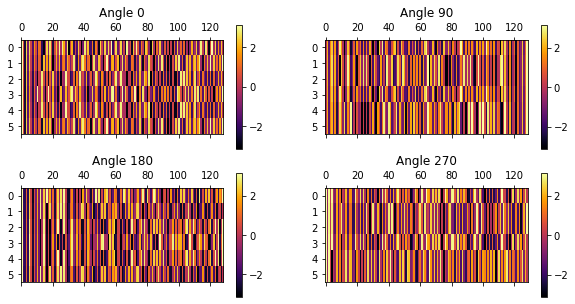

In [82]:
# Get training labels
plot_stfts(X_train, df_train.label)

Try 2D convolution

In [5]:
X_train, X_test = X_train[..., np.newaxis], X_test[..., np.newaxis]
np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test)

((634196, 129, 6, 1), (216388, 129, 6, 1), (634196, 360), (216388, 360))

In [6]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# Init model
model = Sequential()

# Add layers
model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu', input_shape=(n_timesteps,n_features, 1)))
model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 129, 5, 64)        192       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 4, 64)        8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 3, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 129, 2, 64)        8256      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 129, 1, 64)        8256      
_________________________________________________________________
dropout (Dropout)            (None, 129, 1, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8256)              0

In [7]:
epochs, batch_size, verbose = 20, 32, 1
history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size)

Epoch 1/20
19819/19819 [==============================] - 148s 7ms/step - loss: 1.6354 - accuracy: 0.3533
Epoch 2/20
19819/19819 [==============================] - 141s 7ms/step - loss: 1.1818 - accuracy: 0.4947
Epoch 3/20
19819/19819 [==============================] - 144s 7ms/step - loss: 1.0520 - accuracy: 0.5591
Epoch 4/20
19819/19819 [==============================] - 147s 7ms/step - loss: 0.9553 - accuracy: 0.6067
Epoch 5/20
19819/19819 [==============================] - 149s 8ms/step - loss: 0.8845 - accuracy: 0.6424
Epoch 6/20
19819/19819 [==============================] - 146s 7ms/step - loss: 0.8265 - accuracy: 0.6713
Epoch 7/20
19819/19819 [==============================] - 146s 7ms/step - loss: 0.7853 - accuracy: 0.6904
Epoch 8/20
19819/19819 [==============================] - 149s 7ms/step - loss: 0.7500 - accuracy: 0.7074
Epoch 9/20
19819/19819 [==============================] - 146s 7ms/step - loss: 0.7218 - accuracy: 0.7209
Epoch 10/20
19819/19819 [=====================

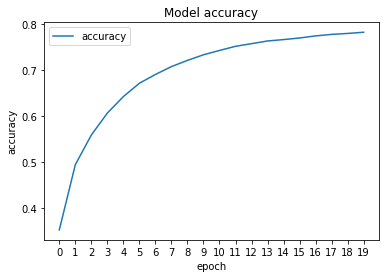

In [20]:
accuracy = history.history['accuracy']
plt.plot(accuracy)
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(range(0, 20))
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

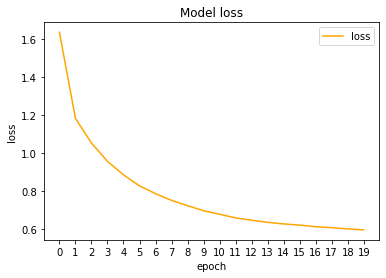

In [21]:
loss = history.history['loss']
plt.plot(loss, color='orange')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(range(0, 20))
plt.legend(['loss'], loc='upper right')
plt.show()

In [ ]:
model.save("../models/stft_2d_model")

In [7]:
model = load_model("../models/stft_2d_model")

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)

6763/6763 [==============================] - 28s 3ms/step - loss: 1.5636 - accuracy: 0.5242


In [10]:
def evaluate_for_property(df_train, df_test, model, prop, value):
    """
    Measures the model prediction for test samples
    with a given property, such as room size.
    """
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Filter test set by property value
    X_trn, y_trn, X_tst, y_tst = create_whole_dataset(
        df_train, df_test[df_test[prop]==value], encoder
    )
    
    X_trn, X_tst = X_trn[..., np.newaxis], X_tst[..., np.newaxis]
    
    # Evaluate the model on the filtered set
    loss, acc = model.evaluate(X_tst, y_tst, batch_size=batch_size, verbose=0)
    return round(loss, 3), round(acc, 3)

In [12]:
epochs, batch_size, verbose = 20, 32, 1
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, model, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, model, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.511
medium room accuracy: 0.525
large room accuracy: 0.536

Distances
50 cm distance accuracy: 0.503
150 cm distance accuracy: 0.535
200 cm distance accuracy: 0.541
250 cm distance accuracy: 0.548
350 cm distance accuracy: 0.517
450 cm distance accuracy: 0.52


Train the model on real audio generated data (1D convolution):

In [16]:
model, _ = create_model(X_train, y_train, X_test, y_test)

Epoch 1/20
19819/19819 [==============================] - 150s 7ms/step - loss: 1.9349 - accuracy: 0.2926
Epoch 2/20
19819/19819 [==============================] - 140s 7ms/step - loss: 1.3460 - accuracy: 0.4357
Epoch 3/20
19819/19819 [==============================] - 133s 7ms/step - loss: 1.2076 - accuracy: 0.4941
Epoch 4/20
19819/19819 [==============================] - 137s 7ms/step - loss: 1.1271 - accuracy: 0.5335
Epoch 5/20
19819/19819 [==============================] - 139s 7ms/step - loss: 1.0697 - accuracy: 0.5630
Epoch 6/20
19819/19819 [==============================] - 141s 7ms/step - loss: 1.0294 - accuracy: 0.5850
Epoch 7/20
19819/19819 [==============================] - 140s 7ms/step - loss: 0.9947 - accuracy: 0.6029
Epoch 8/20
19819/19819 [==============================] - 138s 7ms/step - loss: 0.9651 - accuracy: 0.6208
Epoch 9/20
19819/19819 [==============================] - 134s 7ms/step - loss: 0.9438 - accuracy: 0.6316
Epoch 10/20
19819/19819 [=====================

Evaluate new model:

In [17]:
loss, accuracy = model.evaluate(X_test, y_test)

6763/6763 [==============================] - 25s 4ms/step - loss: 2.4250 - accuracy: 0.5013


In [11]:
# Evaluate performance for different properties
print('Room sizes')
for room in ROOMS:
    _, acc = evaluate_for_property(df_train, df_test, model, 'room', room)
    print(f"{room} room accuracy: {acc}")
    
print('\nDistances')
for dist in np.unique(df_test.dist):
    _, acc = evaluate_for_property(df_train, df_test, model, 'dist', dist)
    print(f"{dist} cm distance accuracy: {acc}")

Room sizes
small room accuracy: 0.485
medium room accuracy: 0.499
large room accuracy: 0.519

Distances
50 cm distance accuracy: 0.362
150 cm distance accuracy: 0.559
200 cm distance accuracy: 0.553
250 cm distance accuracy: 0.581
350 cm distance accuracy: 0.577
450 cm distance accuracy: 0.573


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 127, 64)           1216      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 64)           12352     
_________________________________________________________________
dropout (Dropout)            (None, 125, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8193024   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 360)               3

In [6]:
model.save('../models/stft_model')

INFO:tensorflow:Assets written to: ../models/stft_model\assets


In [85]:
fs, audio = wavfile.read('../training_data/audio/horizontal/train_angle_0_dist_175_room_medium_CantinaBand3.wav')

In [86]:
start = 30000
obs = audio[start:start + 103424]

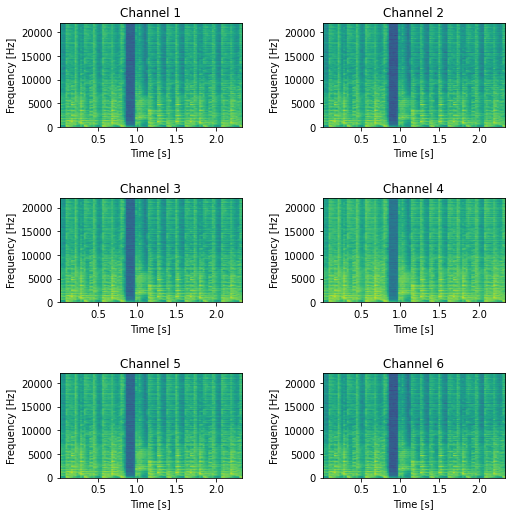

In [88]:
fig, axs = plt.subplots(3, 2, figsize=(8,8))
fig.tight_layout(pad=5.0)
for i, ax in enumerate(axs):
    _, _, _, im = ax[0].specgram(obs.T[i * 2], mode='magnitude', NFFT=2048, noverlap=1024, Fs=44100)
    ax[0].set_title(f'Channel {2 * i + 1}')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Frequency [Hz]')
    
    _, _, _, im = ax[1].specgram(obs.T[i * 2 + 1], mode='magnitude', NFFT=2048, noverlap=1024, Fs=44100)
    ax[1].set_title(f'Channel {2 * i + 2}')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Frequency [Hz]')

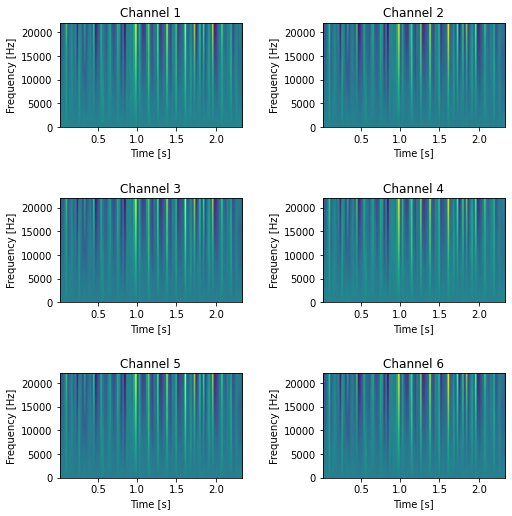

In [99]:
fig, axs = plt.subplots(3, 2, figsize=(8,8))
fig.tight_layout(pad=5.0)
for i, ax in enumerate(axs):
    _, _, _, im = ax[0].specgram(obs.T[i * 2], mode='phase', NFFT=2048, noverlap=1024, Fs=44100)
    ax[0].set_title(f'Channel {2 * i + 1}')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Frequency [Hz]')
    ax[1].specgram(obs.T[i * 2 + 1], mode='phase', NFFT=2048, noverlap=1024, Fs=44100)
    ax[1].set_title(f'Channel {2 * i + 2}')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Frequency [Hz]')